# PCA Cleaning applied to Smoothed Simulated Data
This notebook applies foreground cleaning to the smoothed simulated data. This data is from https://github.com/IntensityTools/MultipoleExpansion and is explored in the notebook 'EXPLORING_THE_SIMULATED_DATA.ipynb'. Here the smoothing function shown in said notebook has been applied to the data. <br/>
Foreground cleaning using PCA is applied using the functions in the script PCA.py which was written from scratch for this project. This is then compared to PCA using sklearn.decomposition.PCA() (https://scikit-learn.org/stable/modules/decomposition.html#pca) as a sanity check to ensure the code is working properly. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from pylab import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors

import PCA 
from sklearn.decomposition import PCA as sklearn_PCA

In [2]:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

In [3]:
### LOAD IN AND RESHAPE DATA ###
T_ALL = np.load('Data/smoothed.npy')
T_ALL = PCA.shaping(T_ALL,xyz=False)

T_HI = np.load('Data/HI-smoothed.npy')
T_HI = PCA.shaping(T_HI,xyz=False)

nx,ny,nz = np.shape(T_HI)

In [4]:
#frequency range 
zz = np.linspace(0.8,0.84,nz)

v = 1420.4/(1+zz)#frequency range

extent=[np.min(v),np.max(v),np.min(v),np.max(v)]

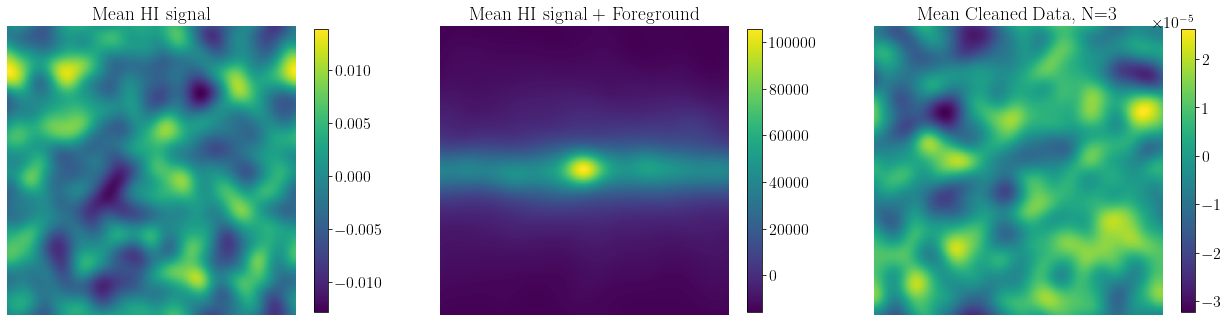

In [22]:
### APPLY PCA TO CLEAN DATA ###
N=3 #number of modes to remove 
dT_ALL = PCA.mean_centre(T_ALL)
FG_est = PCA.fg_est(dT_ALL, N)

cleaned = PCA.clean(T_ALL, FG_est)

#plt.imshow(np.mean(cleaned,2)) #I have changed this to show the mean cleaned data (across z)... think about?
#plt.colorbar();

fig = plt.figure(figsize=(22,8))
fig.subplots_adjust(wspace=0.2)

#plot HI intensity map 
plt.subplot(131)
plt.imshow(np.mean(T_HI,2))
plt.title("Mean HI signal")
plt.axis('off')
plt.colorbar(shrink = 0.65)

#plot HI intenisty map with foreground
plt.subplot(132)
plt.imshow(np.mean(T_ALL,2))
plt.title("Mean HI signal + Foreground")
plt.axis('off')
plt.colorbar(shrink = 0.65)

#plot cleaned data
plt.subplot(133)
plt.imshow(np.mean(cleaned,2))
plt.title("Mean Cleaned Data, N="+ str(N))
plt.axis('off')
plt.colorbar(shrink = 0.65);                     

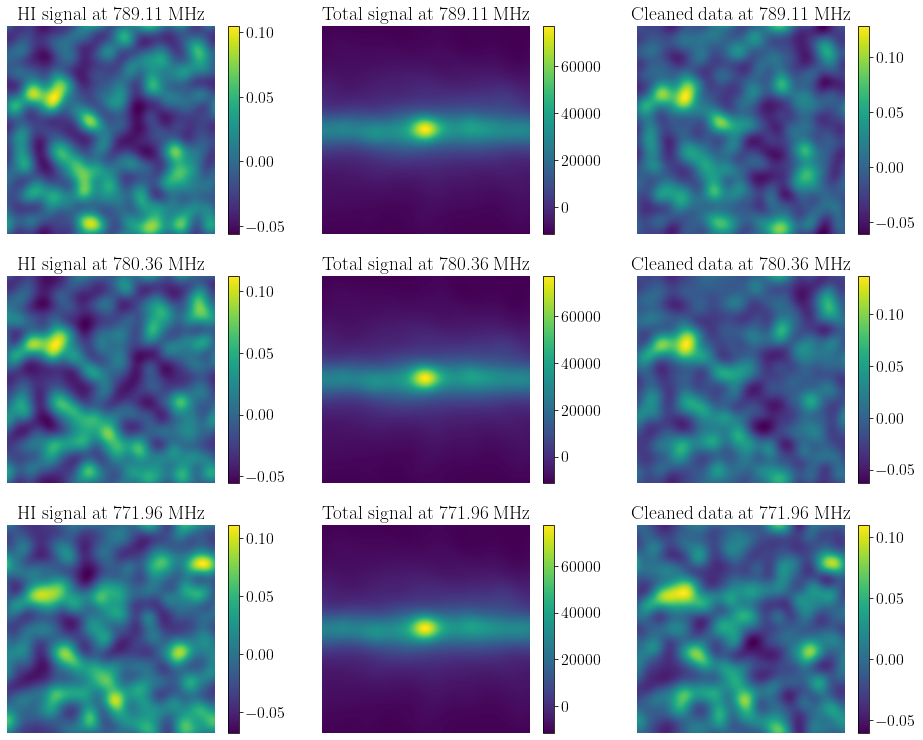

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(16, 13))
freq = [0,113,224]
i = 0
for ax,j in zip(axes.flat,freq): 
    im = axes[i,0].imshow(T_HI[:,:,i]) 
    axes[i,0].set(title=f'HI signal at {np.round(v[j],2)} MHz')
    axes[i,0].axis('off')
    plt.colorbar(im,ax=axes[i,0]);
    
    im = axes[i,1].imshow(T_ALL[:,:,i]) 
    axes[i,1].set(title=f'Total signal at {np.round(v[j],2)} MHz')
    axes[i,1].axis('off')
    plt.colorbar(im,ax=axes[i,1]);
    
    im = axes[i,2].imshow(cleaned[:,:,i]) 
    axes[i,2].set(title=f'Cleaned data at {np.round(v[j],2)} MHz')
    axes[i,2].axis('off')
    plt.colorbar(im,ax=axes[i,2]);
    i+= 1

#fig.savefig('plots/cleaning-smooth-simulated.png')

The total percentage difference between the residuals and the true signal is: -169.47 %


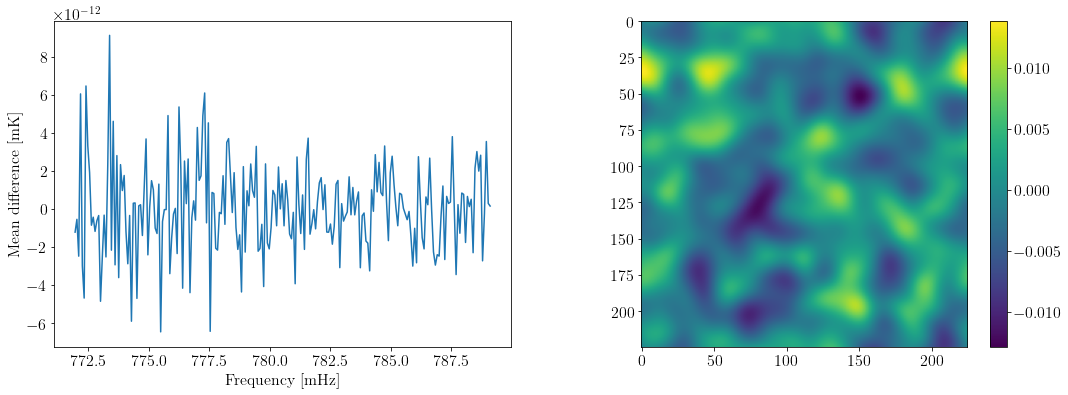

In [7]:
difference = (T_HI - cleaned)
per_diff = (difference/T_HI)*100
print(f'The total percentage difference between the residuals and the true signal is: {np.round(np.mean(per_diff),2)} %')

fig = plt.figure(figsize=(18,6))
fig.subplots_adjust(wspace=0.2)
plt.subplot(121)
mean_diff = np.zeros(nz)
for i in range(nz): 
    mean_diff[i] = np.mean(difference[:,:,i])
    
plt.plot(v,mean_diff) 
plt.xlabel('Frequency [mHz]')
plt.ylabel('Mean difference [mK]');
plt.subplot(122)
plt.imshow(np.mean(difference,2))
plt.colorbar();

### sklearn.decomposition.PCA

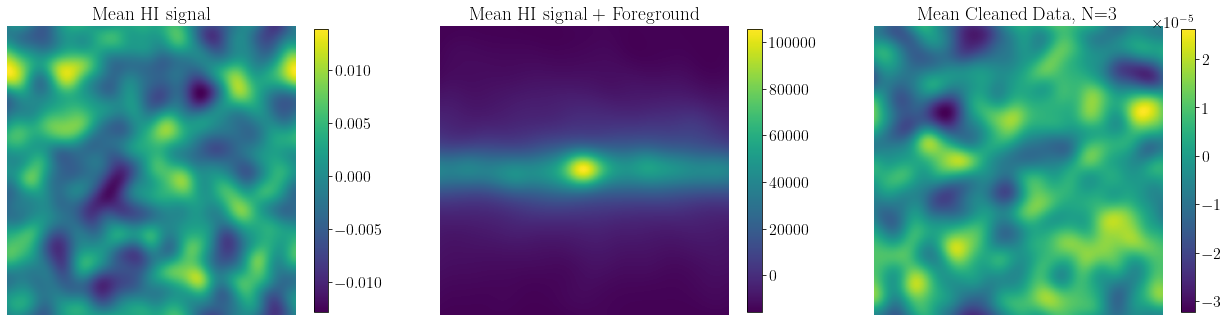

In [8]:
data = np.swapaxes(dT_ALL,0,1) #reshape data to [Npix,Nz] as required for sklearn_PCA
### APPLY PCA TO DATA ### 
pca = sklearn_PCA(n_components=N)
S = pca.fit_transform(data)  # Reconstruct signals 
FG_est = pca.inverse_transform(S)  #estimate foreground
FG_est = FG_est.reshape([225,225,225]) 
FG_est = FG_est 

clean = T_ALL - FG_est  

fig = plt.figure(figsize=(22,8))
fig.subplots_adjust(wspace=0.2)

#plot HI intensity map 
plt.subplot(131)
plt.imshow(np.mean(T_HI,2))
plt.title("Mean HI signal")
plt.axis('off')
plt.colorbar(shrink = 0.65)

#plot HI intenisty map with foreground
plt.subplot(132)
plt.imshow(np.mean(T_ALL,2))
plt.title("Mean HI signal + Foreground")
plt.axis('off')
plt.colorbar(shrink = 0.65)

#plot cleaned data
plt.subplot(133)
plt.imshow(np.mean(clean,2))
plt.title("Mean Cleaned Data, N="+ str(N))
plt.axis('off')
plt.colorbar(shrink = 0.65);                      

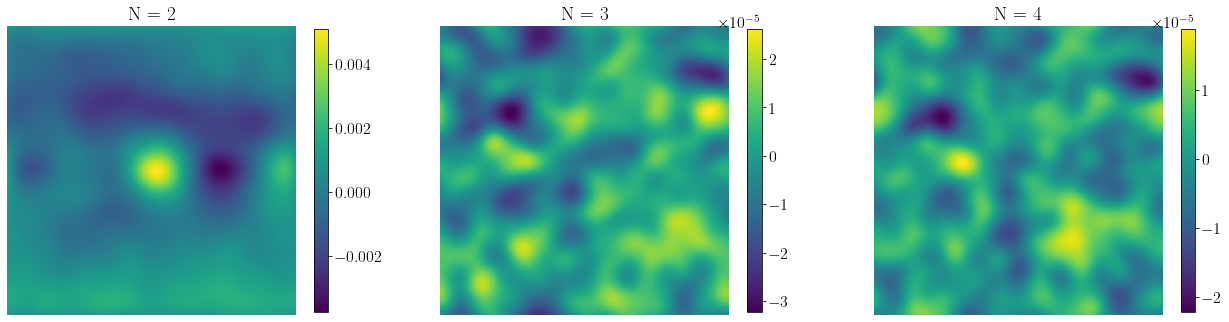

In [9]:
### PLOT THE MEAN CLEANED DATA FOR VARIOUS NUMBERS OF MODES REMOVED ###
N=np.array([2,3,4])
dT_ALL = PCA.mean_centre(T_ALL)


fig,axes = plt.subplots(1,3,figsize=(22,8))
fig.subplots_adjust(wspace=0.2)

for ax,n in zip(axes.flat,N):
    FG_est = PCA.fg_est(dT_ALL, n)
    cleaned = PCA.clean(T_ALL, FG_est)
    im = ax.imshow(np.mean(cleaned,2))
    ax.set(title='N = '+str(n))
    ax.axis('off')
    plt.colorbar(im, shrink =0.65);
    
#fig.savefig('plots/smooth-sims-how-many-modes.png')

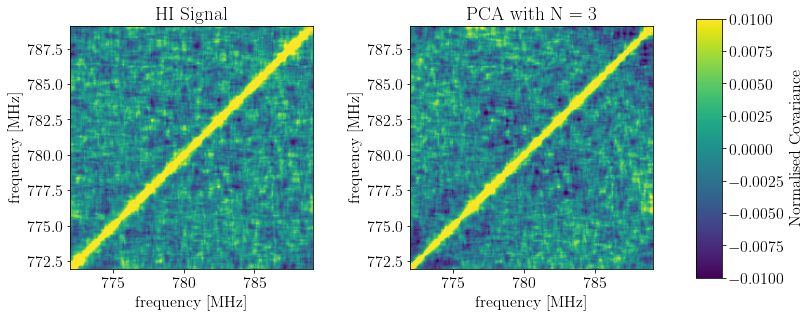

In [10]:
### PLOT COVARIANCE MATRICES###
N=3
FG_est = PCA.fg_est(dT_ALL, N)
cleaned = PCA.clean(T_ALL, FG_est)

fig = plt.figure(figsize=(12,6))
fig.subplots_adjust(wspace=0.4)
norm = mcolors.TwoSlopeNorm(vmin = -0.01,vmax = 0.01,vcenter=0)

#plot covariance matrix of HI signal
plt.subplot(121)
dT_HI = PCA.mean_centre(T_HI)
HI_cov = np.cov(dT_HI)
HI_cov /= np.linalg.norm(HI_cov) 
plt.imshow(HI_cov, origin = 'lower', extent=extent,norm=norm)
plt.title("HI Signal")
plt.xlabel('frequency [MHz]')
plt.ylabel('frequency [MHz]')

#plot covariance matrix of cleaned data
plt.subplot(122)

axes = np.shape(cleaned)
dcleaned = np.reshape(cleaned,(axes[0]*axes[1],axes[2]))     #reshape data so long 1d array of pixels for each z
dcleaned = np.swapaxes(dcleaned,0,1)                                #swap axes so that data in form Nz, Npix
clean_cov = np.cov(dcleaned)
clean_cov /= np.linalg.norm(clean_cov)

im = plt.imshow(clean_cov,extent=extent,origin='lower',norm=norm)
plt.title("PCA with N = "+str(N))
plt.xlabel('frequency [MHz]')
plt.ylabel('frequency [MHz]')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.03, 0.6])
fig.colorbar(im,label="Normalised Covariance",cax=cbar_ax);

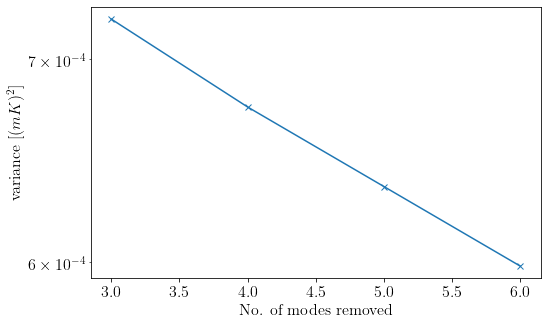

In [11]:
### TOTAL VARIANCE IN RESIDUALS ###
Nlist = np.arange(3,7)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
var_arr_pca_250 = []

for nn,i in zip(Nlist,range(len(Nlist))):
    N_chosen = nn
    
        
    dT_ALL = PCA.mean_centre(T_ALL)
    FG_est = PCA.fg_est(dT_ALL, N=N_chosen)
    cleaned = PCA.clean(T_ALL, FG_est)
    
    var_arr_pca_250.append(np.nanvar(cleaned))
    
var_arr_pca_250 = np.array(var_arr_pca_250)    
ax.plot(Nlist,var_arr_pca_250,'-x',color='tab:blue',label='PCA 250chs')
ax.set(yscale='log')
plt.xlabel('No. of modes removed')
plt.ylabel('variance [$(mK)^2$]')

fig.subplots_adjust(right=0.75) 

### POWER SPECTRUM ANALYSIS
The power spectrum for the orginal signal and residuals are constructed and plotted in order to exmaine the effectiveness of this method of foreground cleaning. <br/>
The functions used to construct power spectrums herein was developed by Paula Soares et al. and is  available at: https://github.com/paulassoares/gpr4im <br/>

In [12]:
import sys
sys.path.append('gpr4im/')
import pk_tools

In [13]:
W_HI = np.ones_like(T_ALL) # Binary mask: 1 where pixel filled, 0 otherwise
W_HI[np.isnan(T_ALL)] = 0
w_HI = np.ones_like(T_ALL)

lx,ly,lz = 1000,1000,762

kmin = 2*np.pi/pow(lx*ly*lz, 1/3)
kmax= 0.3
# set width of k bins to be 2*kmin
dk = 2*kmin
# number of k bins:
nkbin = int((kmax-kmin)/dk)
# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)

In [14]:
dT_ALL = PCA.mean_centre(T_ALL)
FG_est = PCA.fg_est(dT_ALL, N=3)
cleaned = PCA.clean(T_ALL, FG_est)

pk_cleaned = pk_tools.getpk(cleaned,w_HI,W_HI,nx,ny,nz,lx,ly,lz,kbins)[0]
pk_HI = pk_tools.getpk(T_HI,w_HI,W_HI,nx,ny,nz,lx,ly,lz,kbins)[0]

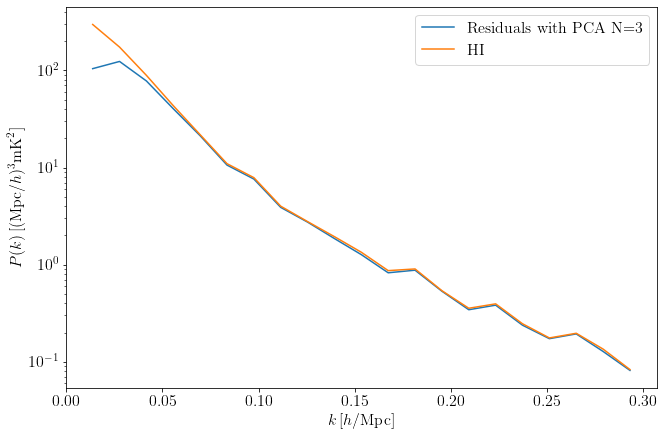

In [15]:
### PLOT POWER SPECTRUM OF SIGNAL AND RESIDUALS FROM PCA WITH N=3 ###
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(3, 2, width_ratios=[1, 0.03], height_ratios=[1, 0.1, 1])
ax = fig.add_subplot(gs[:, 0])
ax.plot(k,(pk_cleaned),label='Residuals with PCA N=3')
ax.plot(k,(pk_HI),label='HI')
ax.legend()
ax.set(yscale='log',xlabel=r'$k\,[h/{\rm Mpc}]$',ylabel=r'$ P(k)\,[({\rm Mpc}/h)^3{\rm mK}^2]$');

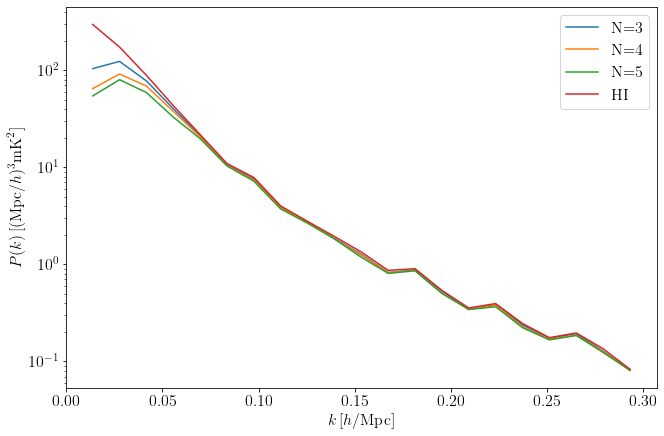

In [16]:
### POWER SPECTRUM OF RESIDUALS FOR DIFFERENT N ###
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(3, 2, width_ratios=[1, 0.03], height_ratios=[1, 0.1, 1])
ax = fig.add_subplot(gs[:, 0])
Nlist = np.arange(3,6)

for nn,i in zip(Nlist,range(len(Nlist))):
    FG_est = PCA.fg_est(dT_ALL,nn)
    cleaned = PCA.clean(T_ALL, FG_est)

    pk_cleaned = pk_tools.getpk(cleaned,w_HI,W_HI,nx,ny,nz,lx,ly,lz,kbins)[0]
    ax.plot(k,(pk_cleaned),label='N='+str(nn))

ax.plot(k,(pk_HI),label='HI')
ax.legend()
ax.set(yscale='log',xlabel=r'$k\,[h/{\rm Mpc}]$',ylabel=r'$ P(k)\,[({\rm Mpc}/h)^3{\rm mK}^2]$');
#fig.savefig('plots/power-spectrum-smooth-sims.png')

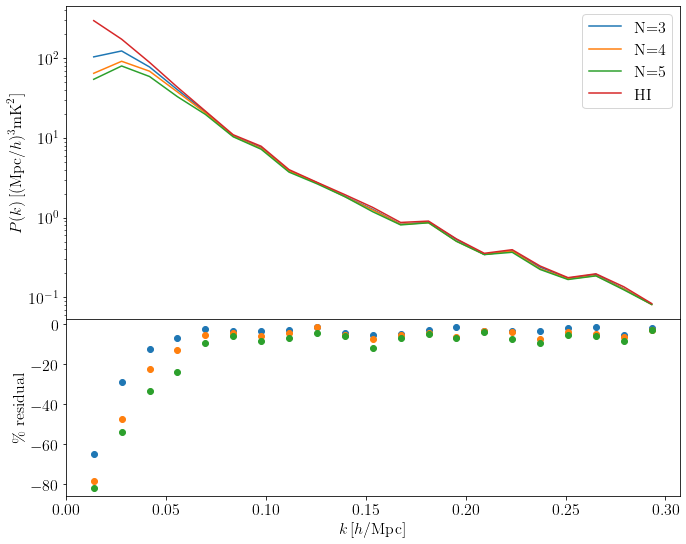

In [17]:
### Residauls ###
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(11,9), 
                               gridspec_kw={'height_ratios': [3, 1.7]})
fig.subplots_adjust(hspace=0, wspace=0.24)

Nlist = np.arange(3,6)

for nn,i in zip(Nlist,range(len(Nlist))):
    FG_est = PCA.fg_est(dT_ALL,nn)
    cleaned = PCA.clean(T_ALL, FG_est)

    pk_cleaned = pk_tools.getpk(cleaned,w_HI,W_HI,nx,ny,nz,lx,ly,lz,kbins)[0]
    ax1.plot(k,(pk_cleaned),label='N='+str(nn))
    diff = 100*(pk_cleaned - pk_HI)/pk_HI
    ax2.scatter(k,(diff),label='N='+str(nn))
       
    
ax1.plot(k,(pk_HI),label='HI')    
#ax.plot(k,(pk_HI),label='HI')
ax1.legend()
ax1.set(yscale='log',ylabel=r'$ P(k)\,[({\rm Mpc}/h)^3{\rm mK}^2]$')
ax2.set(xlabel=r'$k\,[h/{\rm Mpc}]$',ylabel='\% residual');

#fig.savefig('plots/pk-resids-smooth-sims.png')